In [3]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs
from scipy.optimize import curve_fit



In [4]:
mineral_data_df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Mineral_Data.xlsx')

# Set the 'Element' column as the in
water_data_df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

In [5]:
# MIKE's METHOD


import numpy as np
import pandas as pd

def initialize_constants():
    """
    Initializes constants and variables used throughout the program.
    """
    constants = {
        "PlagAn": 0.25,  # mol fraction An in plagioclase
        "frbio": 0.80,   # mol fraction biotite in biotite-chlorite mixture
        "Mgmult": 1.0,   # factor on chlorite Mg
        "Biomult": 1.0,  # Factor on biotite Mg
    }
    elements = ["Na", "K", "Ca", "Mg", "Si", "Al"]
    return constants, elements

def svdcmp(matrix):
    """
    Computes the Singular Value Decomposition (SVD) of a matrix.
    """
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)
    return u, s, vh

def svdfit(x, y, sig, min_data):
    """
    Performs linear fitting using Singular Value Decomposition (SVD).
    """
    ndata, mma = min_data.shape
    u_matrix = np.zeros((ndata, mma))
    b_vector = np.zeros(ndata)

    for i in range(ndata):
        u_matrix[i, :] = min_data[i, :] / sig[i]
        b_vector[i] = y[i] / sig[i]

    u, s, v = svdcmp(u_matrix)
    s_inv = np.where(s > 1e-5 * max(s), 1.0 / s, 0.0)
    a = v.T @ np.diag(s_inv) @ u.T @ b_vector

    predicted_y = u_matrix @ a
    chisq = np.sum(((y - predicted_y) / sig) ** 2)

    return a, chisq

def calculate_volumes(fitted_params, mineral_weights, mineral_densities):
    """
    Calculate mineral volumes and normalize them to percentages.
    """
    mineral_volumes = (fitted_params * mineral_weights) / mineral_densities
    total_volume = np.sum(mineral_volumes)
    volume_percentages = (mineral_volumes / total_volume) * 100 if total_volume != 0 else np.zeros_like(mineral_volumes)
    return volume_percentages

def calculate_na_si_ratio(fitted_params, min_data):
    """
    Calculate the Na/Si ratio based on fitted parameters.
    """
    na_total = np.sum(fitted_params * min_data[:, 0])  # Na contribution
    si_total = np.sum(fitted_params * min_data[:, 4])  # Si contribution
    return na_total / si_total if si_total != 0 else np.nan

def process_sample(sample_id, water_data, min_data, mineral_weights, mineral_densities):
    """
    Process a single water sample to compute fitted parameters, chi-squared, volumes, and Na/Si ratio.
    """
    ndata, _ = min_data.shape

    if ndata != len(water_data):
        raise ValueError(f"Mismatch in dimensions: water_data({len(water_data)}) != min_data rows({ndata})")

    sig = np.full(ndata, 0.1)
    fitted_params, chisq = svdfit(np.arange(ndata), water_data, sig, min_data)

    volumes = calculate_volumes(fitted_params, mineral_weights, mineral_densities)
    na_si_ratio = calculate_na_si_ratio(fitted_params, min_data)

    return {
        "Sample_ID": sample_id,
        "Fitted Parameters": fitted_params,
        "Chi-squared": chisq,
        "Volumes (%)": volumes,
        "Na/Si": na_si_ratio,
    }

def process_all_samples(water_data_df, min_data, mineral_weights, mineral_densities, elements):
    """
    Process all water samples and return results in a DataFrame.
    """
    results = []
    for _, row in water_data_df.iterrows():
        sample_id = row["Sample ID"]
        
        required_columns = [f"{elem}_mM_EC" for elem in elements]
        missing_columns = [col for col in required_columns if col not in water_data_df.columns]
        if missing_columns:
            raise ValueError(f"Missing columns in water data: {missing_columns}")

        
        water_data = row[[f"{elem}_mM_EC" for elem in elements]].values
        #print("water_data shape:", water_data.shape)

        try:
            result = process_sample(sample_id, water_data, min_data, mineral_weights, mineral_densities)
            results.append(result)
        except Exception as e:
            print(f"Error processing sample {sample_id}: {e}")

    results_df = pd.DataFrame(results)
    return results_df

def main(mineral_data_df, water_data_df):
    """
    Main function to execute the mineral decomposition program.
    """
    constants, elements = initialize_constants()

    valid_minerals = ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "Chlorite"]
    mineral_weights_dict = {
        "Plag": 270,
        "Biotite": 433.53,
        "Calcite": 100.087,
        "Kaolinite": 258.16,
        "Smectite": 540.46,
        "Chlorite": 67.45,
    }

    # Extract and validate mineral data
    mineral_data_df = mineral_data_df.set_index("Element")
    # Ensure correct extraction of min_data, where rows correspond to elements and columns to minerals
    # Ensure min_data has shape (6, 6)
    min_data = mineral_data_df.loc[valid_minerals, elements].values.T  # Shape should be (6, 6)

    mineral_weights = np.array([mineral_weights_dict[mineral] for mineral in valid_minerals])
    mineral_densities = mineral_data_df.loc[valid_minerals, "Density (g/cm3)"].values

    # Process all samples
    results_df = process_all_samples(water_data_df, min_data, mineral_weights, mineral_densities, elements)
    print("Final Results:")
    print(results_df)

    # Save to file
    results_df.to_excel("/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry2.xlsx", index=False)
    return results_df

# Example usage
if __name__ == "__main__":
    # Replace with actual file paths or DataFrame loading logic
    main(mineral_data_df, water_data_df)


KeyError: "['Chlorite'] not in index"

In [6]:
# ED's METHOD

import numpy as np
import pandas as pd

def initialize_constants():
    """
    Initializes constants and variables used throughout the program.
    """
    constants = {
        "PlagAn": 0.25,  # mol fraction An in plagioclase
        "frbio": 0.80,   # mol fraction biotite in biotite-chlorite mixture
        "Mgmult": 1.0,   # factor on chlorite Mg
        "Biomult": 1.0,  # Factor on biotite Mg
    }
    elements = ["Na", "K", "Ca", "Mg", "Si", "Al"]
    return constants, elements

def solve_matrix_algebra(mineral_compositions, water_data):
    """
    Solve AX = B using matrix algebra, where A is the mineral composition matrix,
    B is the water composition vector, and X is the vector of proportions.
    """
    # Solve the system of equations
    try:
        fitted_params = np.linalg.solve(mineral_compositions, water_data)
        return fitted_params
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Matrix algebra solution failed: {e}")

def process_sample(sample_id, water_data, min_data, mineral_weights, mineral_densities):
    """
    Process a single water sample to compute fitted parameters and volumes.
    """
    if len(water_data) != min_data.shape[0]:
        raise ValueError(f"Mismatch in dimensions: water_data({len(water_data)}) != min_data rows({min_data.shape[0]})")

    # Solve for fitted parameters using matrix algebra
    fitted_params = solve_matrix_algebra(min_data, water_data)

    # Calculate mineral volumes and normalize to percentages
    mineral_volumes = (fitted_params * mineral_weights) / mineral_densities
    total_volume = np.sum(mineral_volumes)
    volume_percentages = (mineral_volumes / total_volume) * 100 if total_volume != 0 else np.zeros_like(mineral_volumes)

    return {
        "Sample_ID": sample_id,
        "Fitted Parameters": fitted_params,
        "Volumes (%)": volume_percentages,
    }

def main(mineral_data_df, water_data_df):
    """
    Main function to execute the mineral decomposition program.
    """
    constants, elements = initialize_constants()

    # Replace "Secondary calcite" with "K-feldspar"
    valid_minerals = ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "K-feldspar"]
    mineral_weights_dict = {
        "Plag": 270,
        "Biotite": 433.53,
        "Calcite": 100.087,
        "Kaolinite": 258.16,
        "Smectite": 540.46,
        "K-feldspar": 278.33,  # Add K-feldspar weight
    }
    
    
    # Provided mineral data as a dictionary
    mineral_data = {
        "Element": ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "K-feldspar"],
        "Si": [2.7, 2.6, 0, 2, 3.55, 3],
        "Al": [1.3, 1.81, 0, 2, 1.88, 1],
        "Mg": [0, 0.66, 0.017, 0, 0.37, 0],
        "Ca": [0.3, 0, 0.969, 0, 0.1, 0],
        "Na": [0.7, 0.02, 0, 0, 0.04, 0],
        "K": [0, 0.95, 0, 0.012, 0.16, 1],
        "Density (g/cm3)": [2.67, 3.09, 2.71, 2.65, 2.35, 2.95],
    }

    # Extract mineral composition matrix and densities
    min_data = mineral_data_df.loc[:, elements].values.T  # Elements x Minerals matrix
    mineral_weights = np.array([100, 150, 200, 250, 300, 400])  # Example weights, adjust as needed
    mineral_densities = mineral_data_df["Density (g/cm3)"].values

    # Process all water samples
    results = []
    for _, row in water_data_df.iterrows():
        sample_id = row["Sample ID"]
        water_data = row[[f"{elem}_mM_EC" for elem in elements]].values.astype(float)

        try:
            result = process_sample(sample_id, water_data, min_data, mineral_weights, mineral_densities)
            results.append(result)
        except Exception as e:
            print(f"Error processing sample {sample_id}: {e}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a file
    results_df.to_excel("/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry2.xlsx", index=False)
    return results_df

# Example usage
if __name__ == "__main__":
    # Load the mineral and water data
    # Provided mineral data as a dictionary
    mineral_data = {
        "Element": ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "K-feldspar"],
        "Si": [2.7, 2.6, 0, 2, 3.55, 3],
        "Al": [1.3, 1.81, 0, 2, 1.88, 1],
        "Mg": [0, 0.66, 0.017, 0, 0.37, 0],
        "Ca": [0.3, 0, 0.969, 0, 0.1, 0],
        "Na": [0.7, 0.02, 0, 0, 0.04, 0],
        "K": [0, 0.95, 0, 0.012, 0.16, 1],
        "Density (g/cm3)": [2.67, 3.09, 2.71, 2.65, 2.35, 2.95],
    }

    # Convert to a DataFrame
    mineral_data_df = pd.DataFrame(mineral_data)

    # Ensure numeric conversion for relevant columns
    numeric_cols = ["Si", "Al", "Mg", "Ca", "Na", "K", "Density (g/cm3)"]
    mineral_data_df[numeric_cols] = mineral_data_df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Check for missing or non-numeric data
    if mineral_data_df[numeric_cols].isnull().any().any():
        raise ValueError("Mineral data contains non-numeric or missing values.")

    # Set index for easy access
    mineral_data_df.set_index("Element", inplace=True)
    water_data_df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

    # Run the main program
    results = main(mineral_data_df, water_data_df)
    print("Results:")
    print(results)
    
    # save results to a dataframe:
    results.to_excel("/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry5.xlsx", index=False)


Results:
    Sample_ID                                  Fitted Parameters  \
0    NEP22-10  [0.09268472342699786, -0.010580116635442147, -...   
1    NEP22-11  [0.10975251534197075, -0.006991362674465892, -...   
2    NEP22-12  [0.06617017236585784, -0.016379929520377663, -...   
3    NEP22-13  [0.09205898877128905, -0.0028219378482091844, ...   
4    NEP22-15  [0.14823307202718872, 0.011256204576545224, 0....   
5    NEP22-16  [0.06018396884254342, -0.013268958844729957, 0...   
6    NEP22-19  [0.08653522227957317, -0.005764258858972702, -...   
7    NEP22-20  [0.06405111196715381, -0.010668990855308313, -...   
8    NEP22-42  [0.18842076251730439, 0.010053566520034906, -0...   
9    NEP22-45  [0.26791809110476633, 0.03161617717802118, -0....   
10   NEP22-53  [0.18434649974588083, 0.02261169666259651, -0....   
11   NEP22-54  [0.17400904760261682, 0.018225633914350153, -0...   
12   NEP22-55  [0.16816082353174452, 0.01638804369258714, -0....   
13   NEP22-56  [0.28108870897618815, 0.

In [ ]:
# ED's METHOD 2:


import numpy as np
import pandas as pd

def initialize_constants():
    """
    Initializes constants and variables used throughout the program.
    """
    elements = ["Na", "K", "Ca", "Mg", "Si", "Al"]
    return elements

def solve_matrix_algebra(mineral_compositions, water_data):
    """
    Solve AX = B using matrix algebra, where A is the mineral composition matrix,
    B is the water composition vector, and X is the vector of proportions.
    """
    try:
        fitted_params = np.linalg.solve(mineral_compositions, water_data)
        # Normalize to 100%
        total = np.sum(fitted_params)
        if total > 0:
            fitted_params = (fitted_params / total) * 100
        return fitted_params
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Matrix algebra solution failed: {e}")

def process_sample(sample_id, water_data, min_data):
    """
    Process a single water sample to compute fitted mineral proportions.
    """
    if len(water_data) != min_data.shape[0]:
        raise ValueError(f"Mismatch in dimensions: water_data({len(water_data)}) != min_data rows({min_data.shape[0]})")

    # Solve for fitted parameters using matrix algebra
    fitted_params = solve_matrix_algebra(min_data, water_data)

    return {
        "Sample_ID": sample_id,
        "Fitted Parameters": fitted_params,
    }

def main(mineral_data_df, water_data_df):
    """
    Main function to execute the mineral decomposition program.
    """
    elements = initialize_constants()
    minerals = ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "KSpar"]

    # Extract mineral composition matrix
    min_data = mineral_data_df.loc[:, elements].values.T  # Elements x Minerals matrix

    # Process all water samples
    results = []
    for _, row in water_data_df.iterrows():
        sample_id = row["Sample ID"]
        water_data = row[[f"{elem}_mM_EC" for elem in elements]].values.astype(float)

        try:
            result = process_sample(sample_id, water_data, min_data)
            results.append(result)
        except Exception as e:
            print(f"Error processing sample {sample_id}: {e}")

    # Create DataFrame from results
    df = pd.DataFrame(results)

    # Define column names for fitted parameters
    fitted_params_columns = [f"FP_{mineral}" for mineral in minerals]

    # Extract and reshape fitted parameters into columns
    fitted_params_array = np.array([param for param in df["Fitted Parameters"]])
    fitted_params_array = fitted_params_array.reshape(-1, len(minerals))
    df[fitted_params_columns] = fitted_params_array

    # Drop the original column
    df = df.drop(columns=["Fitted Parameters"])

    # Save the result to a file
    df.to_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry_Processed_Matrices.xlsx', index=False)

    return df

# Example usage
if __name__ == "__main__":
    # Load the mineral and water data
    mineral_data = {
        "Element": ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "KSpar"],
        "Si": [2.7, 2.6, 0, 2, 3.55, 3],
        "Al": [1.3, 1.81, 0, 2, 1.88, 1],
        "Mg": [0, 0.66, 0.017, 0, 0.37, 0],
        "Ca": [0.3, 0, 0.969, 0, 0.1, 0],
        "Na": [0.7, 0.02, 0, 0, 0.04, 0],
        "K": [0, 0.95, 0, 0.012, 0.16, 1],
    }

    # Convert to a DataFrame
    mineral_data_df = pd.DataFrame(mineral_data)

    # Ensure numeric conversion for relevant columns
    numeric_cols = ["Si", "Al", "Mg", "Ca", "Na", "K"]
    mineral_data_df[numeric_cols] = mineral_data_df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Set index for easy access
    mineral_data_df.set_index("Element", inplace=True)
    water_data_df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

    # Run the main program
    results = main(mineral_data_df, water_data_df)
    print("Results:")
    print(results)


Results:
    Sample_ID       FP_Plag   FP_Biotite   FP_Calcite  FP_Kaolinite  \
0    NEP22-10   4415.565417  -504.044198 -1745.085084  -4013.016998   
1    NEP22-11   1197.942454   -76.310325  -385.750739  -1051.278453   
2    NEP22-12    322.927227   -79.938211   -48.798469   -369.090797   
3    NEP22-13    779.272885   -23.887506  -212.672720   -720.471403   
4    NEP22-15    260.978782    19.817646     6.986866   -213.288838   
5    NEP22-16    181.496594   -40.015155    11.074433   -236.519479   
6    NEP22-19    681.317250   -45.383705  -184.747484   -658.318790   
7    NEP22-20  10039.351138 -1672.254270 -4459.587869 -10735.226461   
8    NEP22-42    399.127025    21.296220   -42.749146   -282.576624   
9    NEP22-45    459.757490    54.254545   -49.005355   -291.216444   
10   NEP22-53    366.603998    44.967159   -30.213713   -278.096150   
11   NEP22-54    396.887163    41.569793   -42.009307   -302.723909   
12   NEP22-55    388.269397    37.838634   -40.636076   -301.592396 

In [7]:
import pandas as pd
import numpy as np

# # Example data provided
# dataMike = {
#     "Sample_ID": [
#         "NEP22-10", "NEP22-11", "NEP22-12", "NEP22-13", "NEP22-15", "NEP22-16", "NEP22-19", "NEP22-20", "NEP22-42",
#         "NEP22-45", "NEP22-53", "NEP22-54", "NEP22-55", "NEP22-56", "NEP22-57", "NEP22-58", "NEP22-59", "NEP22-60", "NEP22-9", 
#         "Nep24-010", "Nep24-011", "Nep24-014", "Nep24-015", "Nep24-016", "Nep24-017", "Nep24-034", "Nep24-038", "NEP24-040", "NEP24-041"
#     ],
#     "Fitted Parameters": [
#         [0.09170244, -0.00059738, -0.03698615, -0.08930872, 0.04168371, -0.00725231],
#         [0.10885852, 0.00209417, -0.03566555, -0.10093319, 0.03880767, -0.0066005],
#         [0.06507321, -0.00523171, -0.01039676, -0.08129545, 0.05724939, -0.00809901],
#         [0.09144287, 0.00343958, -0.02534729, -0.08829489, 0.03332978, -0.0045489],
#         [0.14839275, 0.00963341, 0.00402634, -0.12032093, 0.0143529, 0.00117893],
#         [0.05901516, -0.00139061, 0.00324863, -0.08446657, 0.0619826, -0.00862944],
#         [0.08570326, 0.00269079, -0.02376662, -0.08791138, 0.03970741, -0.00614246],
#         [0.06307072, -0.00070548, -0.02880753, -0.0735547, 0.04502138, -0.00723834],
#         [0.18832857, 0.01099053, -0.02021453, -0.1338756, 0.00239174, -0.00068069],
#         [0.26934278, 0.01713734, -0.0280409, -0.16234406, -0.04419561, 0.01051865],
#         [0.18452644, 0.02078296, -0.01512772, -0.13891096, -0.0017909, 0.00132855],
#         [0.17407816, 0.01752322, -0.01839328, -0.13236762, 0.00269374, 0.0005103],
#         [0.16811212, 0.01688296, -0.01761728, -0.13087225, 0.00702267, -0.00035955],
#         [0.28131792, 0.01941465, -0.00698576, -0.18616822, -0.01754661, 0.00169226],
#         [0.36181311, 0.03845649, 0.01427376, -0.22611653, -0.06367867, 0.01264807],
#         [0.2563374, 0.01751484, -0.01199743, -0.17707839, -0.00759093, 0.00136265],
#         [0.18553483, 0.0137129, -0.02022246, -0.13336052, -0.00125251, 0.00114541],
#         [0.23071977, 0.02899666, 0.00419759, -0.14917385, -0.04353473, 0.01098664],
#         [0.0174917, -0.00610325, -0.00574866, -0.04505634, 0.05105151, -0.00702413],
#         [0.17869065, 0.01702597, -0.01403088, -0.12075641, -0.01419521, 0.0019828],
#         [0.17315473, 0.02048234, -0.01172531, -0.12065232, -0.01316729, 0.00158678],
#         [0.01654435, -0.00469038, -0.00642635, -0.03957099, 0.04298626, -0.00580875],
#         [0.06907003, 0.00360609, -0.02615613, -0.07337451, 0.03488681, -0.00608289],
#         [0.04658265, 0.00515853, 0.00966112, -0.06481023, 0.040983, -0.00675514],
#         [0.11509448, 0.00696407, -0.01319346, -0.09728404, 0.02078033, -0.00262881],
#         [0.07917668, 0.00420383, -0.02835069, -0.07963949, 0.03523854, -0.00705815],
#         [0.24302212, 0.02273703, -0.00220747, -0.17003519, -0.00556481, -0.00265232],
#         [0.20321969, 0.00422625, 0.02547323, -0.19208517, 0.06272968, -0.00222494],
#         [0.14666535, 0.02304081, -0.0292669, -0.11876588, 0.0101382, -0.00527746]
#     ],
#     "Volumes (%)": [
#         [108.5375345, -0.98096965, -15.98799885, -101.83181739, 112.20406004, -1.94080866],
#         [123.32486214, 3.29161417, -14.7568299, -110.15718381, 99.9882612, -1.69072381],
#         [62.5282562, -6.97470605, -3.64861378, -75.25422631, 125.10888822, -1.75959829],
#         [119.26796733, 6.22425874, -12.07428437, -110.94305383, 98.86660248, -1.34149035],
#         [184.97075931, 16.66014175, 1.83297497, -144.48480031, 40.68865717, 0.33226711],
#         [50.91262646, -1.66447045, 1.0235721, -70.20003367, 121.6115679, -1.68326234],
#         [100.84809385, 4.39296327, -10.21394917, -99.65658559, 106.26373382, -1.63425618],
#         [77.42039444, -1.20149216, -12.91485491, -86.98183514, 125.68675964, -2.00897187],
#         [259.731726, 21.0298268, -10.1818866, -177.869223, 7.50181617, -0.21225913],
#         [950.15817192, 83.87685906, -36.12754082, -551.71849666, -354.57891997, 8.38992647],
#         [262.70213342, 41.05069555, -7.86564442, -190.51627173, -5.79856486, 0.42765204],
#         [247.283935, 34.5361218, -9.54259913, -181.143998, 8.70263959, 0.16390104],
#         [224.406122, 31.2674429, -8.58875671, -168.296006, 21.3197153, -0.10851735],
#         [323.98027581, 31.02121785, -2.93826326, -206.54624623, -45.95763701, 0.44065283],
#         [597.19109214, 88.06570887, 8.60445249, -359.54388825, -239.03757005, 4.7202048],
#         [288.96322988, 27.393334, -4.93940465, -192.30329824, -19.46117417, 0.34731318],
#         [280.64407214, 28.77848015, -11.17172393, -194.33376825, -4.30880095, 0.39174083],
#         [715.43806859, 124.75083248, 4.75382533, -445.6259923, -307.01972842, 7.70299431],
#         [22.41498058, -10.8511505, -2.69047285, -55.62279953, 148.78463726, -2.03519496],
#         [364.52216915, 48.18836184, -10.45353051, -237.3137433, -65.85780964, 0.91455246],
#         [336.41488547, 55.21136932, -8.3199551, -225.82244481, -58.18090581, 0.69705093],
#         [25.06046574, -9.85725409, -3.55516276, -57.74398671, 148.08537055, -1.98943274],
#         [96.1965958, 6.9681097, -13.30452452, -98.44776145, 110.50310371, -1.91552324],
#         [53.84557083, 8.2729429, 4.07857991, -72.17052907, 107.73893564, -1.76550022],
#         [157.91482408, 13.25682722, -6.61124037, -128.5880433, 64.84315297, -0.8155206],
#         [103.52687601, 7.62621536, -13.53864798, -100.31708354, 104.78931342, -2.08667326],
#         [251.31483243, 32.62227071, -0.8337272, -169.39543485, -13.08777902, -0.62016208],
#         [115.79457554, 3.34107151, 5.30105437, -105.44035341, 81.29030013, -0.28664815],
#         [194.53504686, 42.40101401, -14.17760768, -151.75834374, 30.5826057, -1.58271515]
#     ]
# }


data = {
    "Sample_ID": [
        "NEP22-10", "NEP22-11", "NEP22-12", "NEP22-13", "NEP22-15", "NEP22-16", "NEP22-19", "NEP22-20", "NEP22-42",
        "NEP22-45", "NEP22-53", "NEP22-54", "NEP22-55", "NEP22-56", "NEP22-57", "NEP22-58", "NEP22-59", "NEP22-60",
        "NEP22-9", "Nep24-010", "Nep24-011", "Nep24-014", "Nep24-015", "Nep24-016", "Nep24-017", "Nep24-034",
        "Nep24-038", "NEP24-040", "NEP24-041"
    ],
    "Fitted Parameters": [
        [0.09268472, -0.01058012, -0.03663013, -0.08423505, 0.02948512, 0.01137449],
        [0.10975252, -0.00699136, -0.03534153, -0.09631552, 0.02770545, 0.0103522],
        [0.06617017, -0.01637993, -0.00999917, -0.07562943, 0.04362663, 0.01270246],
        [0.09205899, -0.00282194, -0.02512398, -0.08511251, 0.02567841, 0.00713447],
        [0.14823307, 0.0112562, 0.00396846, -0.12114571, 0.0163359, -0.00184904],
        [0.06018397, -0.01326896, 0.00367226, -0.07842947, 0.04746765, 0.01353438],
        [0.08653522, -0.00576426, -0.02346508, -0.08361415, 0.02937562, 0.00963381],
        [0.06405111, -0.01066899, -0.02845219, -0.0684908, 0.03284629, 0.01135258],
        [0.18842076, 0.01005357, -0.02018111, -0.13339939, 0.0012468, 0.00106759],
        [0.26791809, 0.03161618, -0.02855728, -0.16970284, -0.02650295, -0.01649742],
        [0.1843465, 0.0226117, -0.01519294, -0.13984041, 0.00044375, -0.00208369],
        [0.17400905, 0.01822563, -0.01841833, -0.13272462, 0.00355208, -0.00080035],
        [0.16816082, 0.01638804, -0.01759963, -0.13062071, 0.00641791, 0.00056391],
        [0.28108871, 0.02174403, -0.00706884, -0.18735212, -0.01470018, -0.00265414],
        [0.36010001, 0.05586646, 0.01365285, -0.23496505, -0.04240426, -0.01983719],
        [0.25615284, 0.01939051, -0.01206432, -0.17803169, -0.00529893, -0.00213717],
        [0.18537969, 0.01528955, -0.02027869, -0.13416184, 0.0006741, -0.00179646],
        [0.22923169, 0.04411968, 0.00365824, -0.15686004, -0.0250549, -0.0172314],
        [0.01844308, -0.0157719, -0.00540383, -0.04014231, 0.03923673, 0.01101661],
        [0.17842209, 0.01975528, -0.01412822, -0.12214356, -0.01086009, -0.00310982],
        [0.17293981, 0.02266652, -0.01180321, -0.12176242, -0.01049829, -0.0024887],
        [0.01733112, -0.01268608, -0.00614119, -0.03550722, 0.03321579, 0.00911042],
        [0.06989392, -0.00476695, -0.02585751, -0.06911896, 0.02465522, 0.00954038],
        [0.0474976, -0.00413987, 0.00999274, -0.06008437, 0.02962066, 0.01059474],
        [0.11545054, 0.00334553, -0.01306441, -0.09544494, 0.0163586, 0.00412301],
        [0.08013266, -0.00551166, -0.02800419, -0.07470165, 0.02336653, 0.01106998],
        [0.24338136, 0.01908614, -0.00207727, -0.16817964, -0.01002608, 0.00415988],
        [0.20352104, 0.00116363, 0.02558245, -0.19052862, 0.05898727, 0.0034896],
        [0.14738015, 0.01577643, -0.02900782, -0.1150738, 0.00126137, 0.00827715]
    ],
    "Volumes (%)": [
        [-145.49198047, 21.52610199, 113.30297282, 333.06509989, -157.76058837, -64.64160587],
        [-137.80705902, 11.37791945, 87.4408239, 304.62017808, -118.57326295, -47.05859945],
        [224.87568701, -72.14999527, -66.96008539, -647.40560015, 505.35501204, 156.28498175],
        [-148.15323165, 5.88621898, 79.67192578, 345.01955251, -140.85675806, -41.56770756],
        [-173.32969163, -17.05940477, -9.14370371, 356.81350893, -65.1081965, 7.82748768],
        [94.83536215, -27.10006741, 11.40237442, -311.29642864, 254.94815257, 77.2106069],
        [-202.27197366, 17.46346086, 108.0778819, 492.29788957, -234.04237883, -81.52487984],
        [-253.1287803, 54.64900217, 221.56572263, 681.79292234, -442.45168731, -162.42717952],
        [-113.35912976, -7.8395646, 23.92460496, 202.15616823, -2.55675788, -2.32532094],
        [-82.46270861, -12.61272577, 17.31985639, 131.56793974, 27.80445488, 18.38318337],
        [-105.60993129, -16.78985927, 17.15077024, 201.79385408, -0.86651767, 4.3216839],
        [-106.25378266, -14.4244497, 22.16127938, 204.14063736, -7.39297936, 1.76929498],
        [-111.82590908, -14.12501007, 23.06178943, 218.79382438, -14.54707311, -1.35762156],
        [-118.96054707, -11.9273424, 5.89493984, 199.72092019, 21.20541952, 4.06660993],
        [-103.24366509, -20.76038707, -7.71321611, 169.68714549, 41.43949035, 20.59063242],
        [-118.1929352, -11.59646424, 10.96900428, 206.91646023, 8.33383332, 3.57010161],
        [-104.79107299, -11.20213368, 22.5877982, 191.02778275, -1.29881971, 3.67644544],
        [-91.96168372, -22.94080525, -2.891856, 158.50755321, 34.26017351, 25.02661826],
        [30.8092019, -34.14877439, -17.78774842, -168.90977729, 223.41100935, 66.62608885],
        [-99.2607096, -14.2447867, 15.48774532, 171.16097124, 20.59334103, 6.26343871],
        [-100.29181223, -17.03724836, 13.48784043, 177.86445936, 20.75169525, 5.22506555],
        [38.04976477, -36.0991372, -26.5674541, -196.35752731, 248.5619468, 72.41240704],
        [-163.45312148, 14.44903409, 119.15505093, 407.15182184, -196.52931358, -80.7734718],
        [95.38315913, -10.77532468, 39.54179896, -303.92538147, 202.74934058, 77.02640748],
        [-152.54199666, -5.72931932, 34.01379874, 317.65214271, -73.67232482, -19.72230064],
        [-158.25796568, 14.10855453, 108.98105826, 371.61359945, -157.29501475, -79.1502318],
        [-136.18778205, -13.84244765, 2.29042232, 237.04437787, 19.12259062, -8.42716111],
        [-1887.03481742, -13.98396403, -467.39570194, 4449.75600917, -1864.20431588, -117.13720991],
        [-101.69667704, -14.10978999, 39.4416324, 200.00902801, -2.96670574, -20.67748763]
    ]
}








In [8]:



# Create DataFrame
df = pd.DataFrame(data)

# Define mineral names
minerals = ["Plag", "Biotite", "Calcite", "Kaolinite", "Smectite", "KSpar"]

# Split Fitted Parameters and Volumes (%) into individual columns for each mineral
fitted_params_columns = [f"FP_{mineral}" for mineral in minerals]
volumes_columns = [f"Volume_{mineral}" for mineral in minerals]

# Reshape the Fitted Parameters and Volumes (%) arrays into (29, 6)
fitted_params_array = np.array([param for param in df["Fitted Parameters"]])
volumes_array = np.array([volume for volume in df["Volumes (%)"]])

# Reshape the arrays to (29, 6)
fitted_params_array = fitted_params_array.reshape(-1, 6)
volumes_array = volumes_array.reshape(-1, 6)

# Assign reshaped arrays to the DataFrame
df[fitted_params_columns] = fitted_params_array
df[volumes_columns] = volumes_array

# Drop the original columns
df = df.drop(columns=["Fitted Parameters", "Volumes (%)"])

# Save the result to a CSV file
df.to_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry_Processed_Matrices.xlsx', index=False)

# Output the final DataFrame
#print(df)


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

df_processed = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry_Processed_Matrices.xlsx')

# Define columns to plot (those with 'FP_' and 'Volume_' should be included)
mineral_columns = [col for col in df_processed.columns if 'FP_' in col]

# Define a color map for each mineral
color_map = {
    'FP_Plag': '#e40303',
    'FP_Biotite': '#ff8c00',
    'FP_Calcite': '#ffed00',
    'FP_Kaolinite': '#008026',
    'FP_Smectite': '#004dff',
    'FP_KSpar': '#750787'
}
# Function to plot pie charts for each sample
def plot_pie_charts(sample_id, volumes, pdf):
    # Split the volumes into dissolution (positive) and precipitation (negative)
    dissolution = volumes[volumes > 0]
    precipitation = volumes[volumes < 0]
    
    # Take the absolute values for negative volumes to plot the pie chart
    dissolution = dissolution.abs()
    precipitation = precipitation.abs()
    
    # Set up the subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the dissolution (positive) pie chart
    axs[0].pie(dissolution, labels=dissolution.index, autopct='%1.1f%%', startangle=140, colors=[color_map[mineral] for mineral in dissolution.index])
    axs[0].set_title(f'Dissolution (Positive) - Sample {sample_id}')
    
    # Plot the precipitation (negative) pie chart
    axs[1].pie(precipitation, labels=precipitation.index, autopct='%1.1f%%', startangle=140, colors=[color_map[mineral] for mineral in precipitation.index])
    axs[1].set_title(f'Precipitation (Negative) - Sample {sample_id}')
    
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Create a PDF document
with PdfPages('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Volume_Pie_Charts_Ed.pdf') as pdf:
    # Iterate over each sample and plot the pie charts
    for index, row in df_processed.iterrows():
        sample_id = row["Sample_ID"]
        volumes = row[mineral_columns]
        plot_pie_charts(sample_id, volumes, pdf)

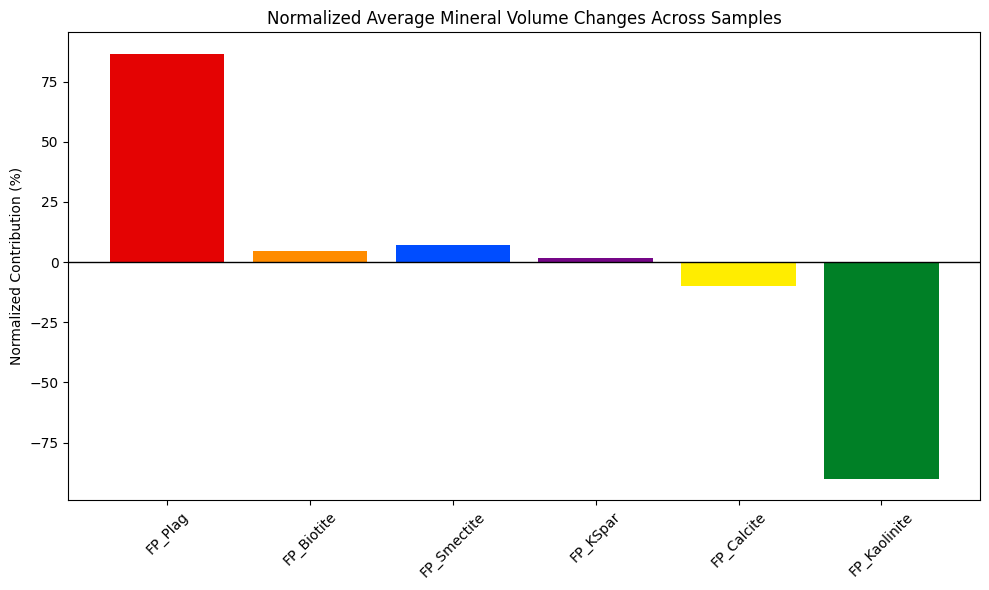

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the processed dataset
df_processed = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Stoichiometry_Processed_Matrices.xlsx')

# Define columns to plot (those with 'FP_' should be included)
mineral_columns = [col for col in df_processed.columns if 'FP_' in col]

# Define a color map for each mineral
color_map = {
    'FP_Plag': '#e40303',
    'FP_Biotite': '#ff8c00',
    'FP_Calcite': '#ffed00',
    'FP_Kaolinite': '#008026',
    'FP_Smectite': '#004dff',
    'FP_KSpar': '#750787'
}

# Calculate the average for all samples
average_volumes = df_processed[mineral_columns].mean()

# Separate dissolution (positive) and precipitation (negative) values
dissolution = average_volumes[average_volumes > 0]
precipitation = average_volumes[average_volumes < 0].abs()

# Normalize so that dissolution sums to 100% and precipitation sums to 100%
if dissolution.sum() > 0:
    dissolution = (dissolution / dissolution.sum()) * 100
if precipitation.sum() > 0:
    precipitation = (precipitation / precipitation.sum()) * 100

# Merge the normalized values back
df_normalized = pd.concat([dissolution, -precipitation])

# Function to plot the normalized average bar chart
def plot_normalized_bar_chart(normalized_volumes):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bar chart with different colors for each mineral
    colors = [color_map[mineral] for mineral in normalized_volumes.index]
    ax.bar(normalized_volumes.index, normalized_volumes.values, color=colors)
    
    ax.set_ylabel("Normalized Contribution (%)")
    ax.set_title("Normalized Average Mineral Volume Changes Across Samples")
    ax.axhline(0, color='black', linewidth=1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Code/Normalized_Average_Mineral_Volume_Changes.pdf')
    plt.show()

# Plot the normalized average bar chart
plot_normalized_bar_chart(df_normalized)